5DOF Inverse Kinematics using IKPY
==================================

This is a demo of how to use IKPY to move a 6DOF robot arm.

Please don't comment and tell me how rubbish this code is, it's meant to demonstrate how easy this is to use, not to show off mad Python skills.

We'll start by importing all our libraries

In [1]:
import ikpy.chain
import ikpy.utils.plot as plot_utils

import numpy as np
import time
import math

import ipywidgets as widgets
#import serial

Now, we can import our robot arm model from the URDF file. The first link is the link between the desk and the base, so we set it to inactive

In [2]:
#my_chain = ikpy.chain.Chain.from_urdf_file("arm_urdf.urdf",active_links_mask=[False, True, True, True, True, True, True])

Second file ---- our cv robot

In [3]:
my_chain = ikpy.chain.Chain.from_urdf_file(
        "urdfs/s.urdf",
    base_elements=["base"],
    active_links_mask=[False, True, True, True, True, True]  # Adjusted to six elements
)

FileNotFoundError: [Errno 2] No such file or directory: 's.urdf'

And set the initial position and orientation of the last joint

In [9]:
target_position = [ 0, 0,-0.58]

target_orientation = [-1, 0, 0]

It's now just one call to work out he inverse kinematics for that position. Again, the first angle is of the inactive joint between the desk and the base so is always 0

In [10]:
ik = my_chain.inverse_kinematics(target_position, target_orientation, orientation_mode="Y")
print("The angles of each joints are : ", list(map(lambda r:math.degrees(r),ik.tolist())))

The angles of each joints are :  [0.0, 89.99996287318955, -90.00021045914797, -90.00021033166375, -33.34025527268155, 0.0]


We can see that actual position our robot will move to. This may be different to _target_position_ as the arm may not be physically able to reach that position

In [11]:
computed_position = my_chain.forward_kinematics(ik)
print("Computed position: %s, original position : %s" % (computed_position[:3, 3], target_position))
print("Computed position (readable) : %s" % [ '%.2f' % elem for elem in computed_position[:3, 3] ])

Computed position: [-6.22748986e-08 -9.61054509e-02 -4.33917785e-01], original position : [0, 0, -0.58]
Computed position (readable) : ['-0.00', '-0.10', '-0.43']


Now, lets visualise what our arm looks

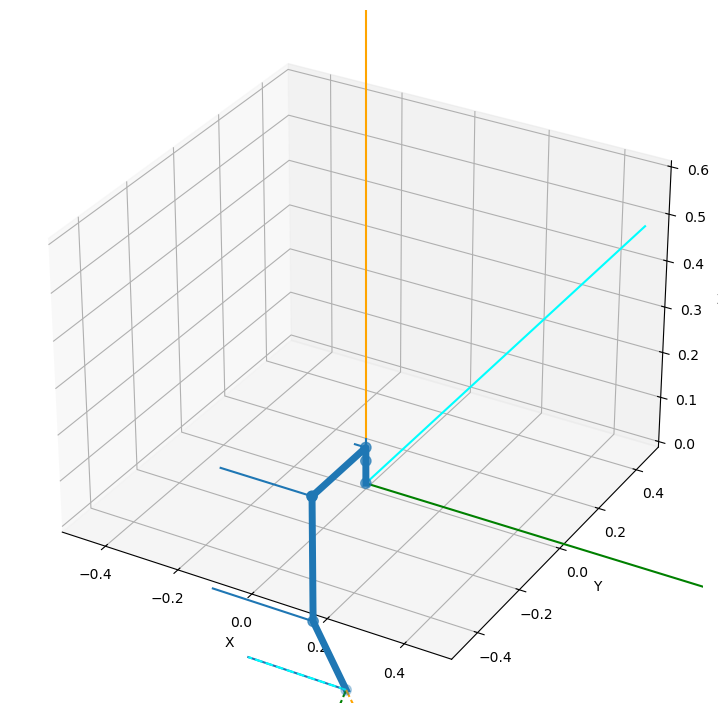

In [12]:

#%matplotlib widget
import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
fig.set_figheight(9)  
fig.set_figwidth(13)  
my_chain.plot(ik, ax, target=target_position)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.set_zlim(0, 0.6)
plt.ion()

Let's now make wrap up some of these calls into a couple of functions. Calling _move(x,y,z)_ will move us to the new coordinates and update the plot.

It's worth noting here that when we call _inverse_kinematcs_, we pass in the old position (joint angles) as _initial_position_ so IKPY find the nearest solution to our current position.

In [8]:
def doIK():
    global ik
    old_position= ik.copy()
    ik = my_chain.inverse_kinematics(target_position, target_orientation, orientation_mode="Z", initial_position=old_position)

def updatePlot():
    ax.clear()
    my_chain.plot(ik, ax, target=target_position)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    ax.set_zlim(0, 0.6)
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def move(x,y,z):
    global target_position
    target_position = [x,y,z]
    doIK()
    updatePlot()

    #sendCommand(ik[1].item(),ik[2].item(),ik[3].item(),ik[4].item(),ik[5].item(),ik[6].item(),1)

We should now be able to move our visualised arm with a call to _move(x,y,z)_

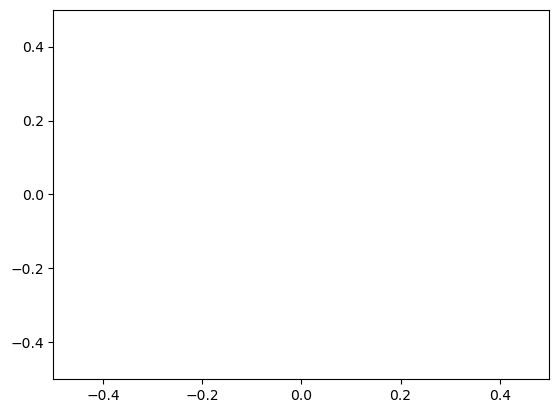

In [9]:
move(0,0.2,0.3)

Let's now connect to our robot arm and create a function to send the angles to it. We just have to uncomment that _sendcommand_ line in the move function to make this work

In [152]:
ser = serial.Serial('COM3',9600, timeout=1)

def sendCommand(a,b,c,d,e,f,move_time):
    command = '0{:.2f} 1{:.2f} 2{:.2f} 3{:.2f} 4{:.2f} 5{:.2f} t{:.2f}\n'.format(math.degrees(a),math.degrees(b),math.degrees(c),math.degrees(d),math.degrees(e),math.degrees(f),move_time)
    ser.write(command.encode('ASCII'))

In [123]:
# we'll call sendCommand once with a move time of 4s so the robot slowly moves to the initial point
sendCommand(ik[1].item(),ik[2].item(),ik[3].item(),ik[4].item(),ik[5].item(),ik[6].item(),4)

But that's a bit boring, why don't we hook up a game controller and make the joysticks move the visualised arm!

In [10]:
import ipywidgets as widgets
con = widgets.Controller()
display(con)

Controller()

We'll need a task running in the background to monitor the controller and call move. Pressing the start button on the controller will end this task.

In [ ]:
import asyncio

async def main():
    x=0
    y=0.25
    z=0.1
    while con.buttons[9].value<1:
        xp=con.axes[0].value
        yp=con.axes[1].value
        zp=con.axes[2].value
        if(abs(xp)>0.1 or abs(yp)>0.1 or abs(zp)>0.1):
            x=x+xp/100
            y=y-yp/100
            z=z-zp/100
            move(x,y,z)
        await asyncio.sleep(0.05)


loop = asyncio.get_event_loop()
loop.create_task(main())

<Task pending name='Task-12' coro=<main() running at C:\Users\ro_ir\AppData\Local\Temp\ipykernel_14128\3951641839.py:3>>

And, when we're done we can close the serial port.

In [156]:
ser.close() 